In [35]:
import pandas as pd 
import numpy as np
import pickle
from collections import defaultdict
import tensorflow as tf

def read_file(filename):
  with open(filename, "rb") as file:
      stat = pickle.load(file)
      file.close()
  return stat

def get_origin_path(stat):
    path_link = stat['data']['paths_link']
    od = [k for k in path_link.keys()]
    path1 = [tuple(p[0]) if len(p) > 0 else np.nan for p in path_link.values()]
    path2 = [tuple(p[1]) if len(p) > 1 else np.nan for p in path_link.values()]
    path3 = [tuple(p[2]) if len(p) > 2 else np.nan for p in path_link.values()]

    demand_dic = stat["data"]["demand"]
    demand = [v for v in demand_dic.values()]
    path_link_df = pd.DataFrame({"od": od, "demand":demand, "path1": path1, "path2": path2, "path3": path3})
    return path_link_df

def get_UE_link_cost(stat):
    # return a dataframe of link cost, link flow
    link = stat['data']['network'].copy()
    link['link_flow'] = stat['link_flow']
    # Calculate link cost
    link['link_cost'] = round(link['free_flow_time']*\
                            (1+link['b']*((link['link_flow']/link['capacity'])**4)), 2)
    return link

# Calculate path travel time for each od pair
def calculate_path_cost(row, link_df):
    if pd.isna(row): 
        return np.nan
    
    sum_time = 0
    for l in row:
        sum_time += link_df.at[l, 'link_cost']
    return round(sum_time, 2)

# calculate each link flow based on path flow
def extract_link_flow(path_link, flows):
    # input: a dictionary of {od pair: path_link} and list of flow distribution
    # return a dictionary of link flow
    path_flow = {}
    for path_set, flow_set in zip(path_link.values(), flows):
        for path, flow in zip(path_set, flow_set):
            path_flow[tuple(path)] = flow

    aggregated_sums = defaultdict(float)
    for path, flow in path_flow.items():
        for link in path:
            aggregated_sums[link] += flow
    link_flow = dict(aggregated_sums)
    return link_flow

# Check UE of origin dataset 
def mean_path_cost(filename):
    stat = read_file(filename)
    path_link_df = get_origin_path(stat)
    UE_link = get_UE_link_cost(stat)

    path_link_df['path1_cost'] = path_link_df['path1'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path2_cost'] = path_link_df['path2'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path3_cost'] = path_link_df['path3'].apply(lambda x: calculate_path_cost(x, UE_link))

    flows = stat['path_flow']
    path_link_df['flow1'] = [f[0] if len(f)>0 else 0 for f in flows]
    path_link_df['flow2'] = [f[1] if len(f)>1 else 0 for f in flows]
    path_link_df['flow3'] = [f[2] if len(f)>2 else 0 for f in flows]

    mean_path_cost = (np.nanmean(path_link_df['path1_cost']) + np.nanmean(path_link_df['path2_cost']) + np.nanmean(path_link_df['path3_cost']))/3
    return UE_link, path_link_df, mean_path_cost

def sum_pred_link_flow(pred_df, stat):
    pred_path_flow = pred_df[['flow1', 'flow2', 'flow3']].values.tolist()
    path_link = stat['data']['paths_link']

    pred_link_flow = extract_link_flow(path_link, pred_path_flow)
    pred_link_flow = pd.DataFrame.from_dict(pred_link_flow, orient='index', columns=['link_flow']).sort_index(ascending=True).reset_index()
    pred_link_flow.rename(columns={'index': 'link_id'}, inplace=True)
    link = stat['data']['network'].copy()[['link_id', 'capacity', 'free_flow_time', 'b']]
    output = pd.merge(link, pred_link_flow, how='left', on='link_id')
    output = output.fillna(0)
    output['link_cost'] = round(output['free_flow_time']*\
                            (1+output['b']*((output['link_flow']/output['capacity'])**4)), 2)
    return output

def calculate_delay(pred_df, pred_link_flow):
    pred_df['path1_cost'] = pred_df['path1'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path2_cost'] = pred_df['path2'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path3_cost'] = pred_df['path3'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['min_path_cost'] = pred_df[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    pred_df['delay'] = (
        pred_df['flow1'] * (pred_df['path1_cost'] - pred_df['min_path_cost']) +
        pred_df['flow2'] * (pred_df['path2_cost'] - pred_df['min_path_cost']) +
        pred_df['flow3'] * (pred_df['path3_cost'] - pred_df['min_path_cost'])
    )
    avg_delay = pred_df['delay'].sum()/pred_df['demand'].sum()
    #return average delay in minutes
    return avg_delay
# path_link_df.head()

In [2]:
def add_link_id_to_tntp(file_path):
    # Read the original file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Find the line with the column headers
    start_index = None
    for i, line in enumerate(lines):
        if line.startswith("~\tinit_node"):
            start_index = i
            break
    
    if start_index is None:
        raise ValueError("The file does not contain the expected header line.")

    # Prepare the new content with link_id
    new_lines = []
    new_lines.extend(lines[:start_index + 1])  # Copy metadata and header

    # Add the new column header for link_id
    header_line = lines[start_index].strip()
    new_header_line = "~\tlink_id\t" + header_line[2:]
    new_lines[start_index] = new_header_line + "\n"
    
    # Add link_id to each data line
    link_id = 0
    for line in lines[start_index + 1:]:
        if line.strip():  # Skip any empty lines
            new_line = f"\t{link_id}\t" + line.strip() + "\n"
            new_lines.append(new_line)
            link_id += 1

    # Save the modified content back to the file
    with open(file_path, 'w') as file:
        file.writelines(new_lines)

# Path to the .tntp file
file_path = '/Users/viviane/Desktop/Internship/Path_Flow_Prediction/Generate_data/Random/Network_5_5.tntp'

# Add link_id and save the file
add_link_id_to_tntp(file_path)

In [30]:
%run utils.py

file_name = "../Solution/SiouxFalls/Testing/5by5_Data0"
stat = read_file(file_name)
net = stat["data"]["network"]
# Number of nodes
nodes = 24

# Generate all possible pairs of 2 nodes from the 24 nodes
all_node_pairs = {(i, j):1 for i in range(1, nodes + 1) for j in range(1, nodes + 1) if i != j}
print(len(all_node_pairs))
paths, path_N = find_paths(net, all_node_pairs, 3)

# Encode all feasible paths
unique_values_set = {tuple(path) for path_set in paths.values() for path in path_set}
path_set_dict = {v: k for k, v in enumerate(unique_values_set, start=1)}
len(path_set_dict)

552


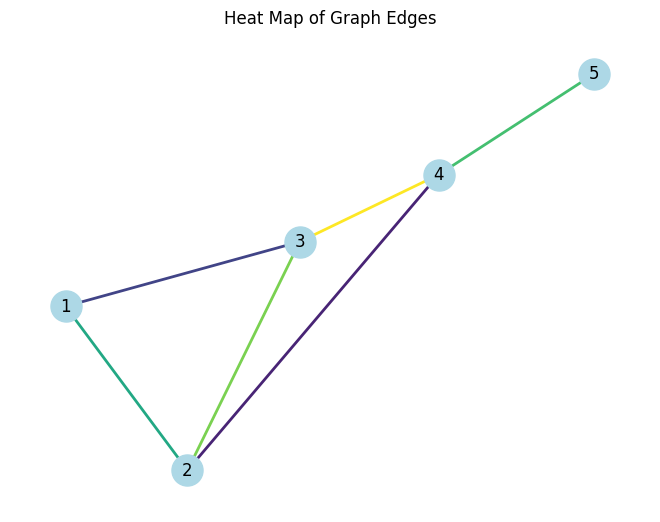

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Bước 1: Tạo đồ thị và gán trọng số cho các cạnh
G = nx.Graph()
edges = [
    (1, 2, 0.6),
    (1, 3, 0.2),
    (2, 3, 0.8),
    (2, 4, 0.1),
    (3, 4, 1),
    (4, 5, 0.7)
]

G.add_weighted_edges_from(edges)

# Bước 2: Chuyển đổi trọng số thành màu sắc cho heat map
weights = [G[u][v]['weight'] for u,v in G.edges()]
colors = plt.cm.viridis(weights)

# Bước 3: Vẽ đồ thị với heat map cho các cạnh
pos = nx.spring_layout(G)  # Bố cục đồ thị

# Vẽ các cạnh với màu sắc dựa trên trọng số
nx.draw(G, pos, edge_color=colors, width=2, with_labels=True, node_color='lightblue', node_size=500)

# Hiển thị thanh màu (color bar)
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
sm.set_array([])
# plt.colorbar(sm, label='Edge Weight')

plt.title('Heat Map of Graph Edges')
plt.show()


In [12]:
from tqdm import tqdm

sum_avg, cost = [], []
size = 10
for i in tqdm(range(size)):
    file_name = f"../Solution/SiouxFalls/Testing/5by5_Data{i}"
    UE_link, df, mean_cost = mean_path_cost(file_name)
    delay = calculate_delay(df, UE_link)
    sum_avg.append(delay)
    cost.append(mean_cost)

delay = np.mean(sum_avg)
mean_cost = np.mean(cost)

print("Mean path cost: ", mean_cost, " mins")
print("Delay: ", delay, " mins = ", round(delay/mean_cost*100, 2), "%")

100%|██████████| 10/10 [00:00<00:00, 23.60it/s]

Mean path cost:  20.36344261809939  mins
Delay:  0.005964335296226965  mins =  0.03 %


In [23]:
# Average path cost

for j in range(4):
    sum_avg, cost = [], []
    size = 1000
    for i in tqdm(range(size)):
        file_name = f"../Solution/EMA/Output{j+1}/5by5_Data{i}"
        UE_link, df, mean_cost = mean_path_cost(file_name)
        delay = calculate_delay(df, UE_link)
        sum_avg.append(delay)
        cost.append(mean_cost)

    delay = np.mean(sum_avg)
    mean_cost = np.mean(cost)

    print("Mean path cost: ", mean_cost, " minutes")
    print("Delay: ", delay, " minutes = ", round(delay/mean_cost*100, 2), "%")

100%|██████████| 1000/1000 [00:19<00:00, 51.94it/s]


Mean path cost:  19.07080346052123  minutes
Delay:  0.004756556912802233  minutes =  0.02 %


100%|██████████| 1000/1000 [00:18<00:00, 52.65it/s]


Mean path cost:  27.37388129290902  minutes
Delay:  0.009307877732595261  minutes =  0.03 %


100%|██████████| 1000/1000 [00:19<00:00, 51.71it/s]


Mean path cost:  36.46728436752656  minutes
Delay:  0.008889134036467216  minutes =  0.02 %


100%|██████████| 1000/1000 [00:19<00:00, 52.52it/s]

Mean path cost:  98.87650931697874  minutes
Delay:  0.03522099576284346  minutes =  0.04 %


In [8]:
filename = '../Solution/Output3/5by5_Data0'
stat = read_file(filename)
# a = get_UE_link_cost(stat)
UE_link, path_link_df, mean_path_cost = mean_path_cost(filename)
UE_link

,~,link_id,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,;,link_flow,link_cost
0,NaN,0,1,2,25900.200640,6,6,0.15,4,0,0,1,;,2181.0,6.00
1,NaN,1,1,3,23403.473190,4,4,0.15,4,0,0,1,;,11055.0,4.03
2,NaN,2,2,1,25900.200640,6,6,0.15,4,0,0,1,;,2927.0,6.00
3,NaN,3,2,6,4958.180928,5,5,0.15,4,0,0,1,;,4529.0,5.52
4,NaN,4,3,1,23403.473190,4,4,0.15,4,0,0,1,;,9348.0,4.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,NaN,71,23,22,5000.000000,4,4,0.15,4,0,0,1,;,4036.0,4.25
61,NaN,72,23,24,5078.508436,2,2,0.15,4,0,0,1,;,891.0,2.00
62,NaN,73,24,13,5091.256152,4,4,0.15,4,0,0,1,;,3586.0,4.15
63,NaN,74,24,21,4885.357564,3,3,0.15,4,0,0,1,;,15600.0,49.79


In [11]:
path_link_df

,od,demand,path1,path2,path3,path1_cost,path2_cost,path3_cost,flow1,flow2,flow3
0,"(1, 25)",161,"(0, 2, 15, 29, 44, 48, 51, 63)","(0, 2, 15, 29, 45, 57, 60, 63)","(0, 2, 15, 29, 44, 49, 60, 63)",830.07,827.86,830.44,0.0,161.0,0.0
1,"(7, 20)",111,"(14, 18, 20, 23, 40)","(15, 29, 44, 46, 32, 36, 40)","(14, 16, 4, 7, 20, 23, 40)",728.54,714.36,742.70,111.0,0.0,0.0
2,"(1, 22)",14,"(0, 2, 15, 29, 45)","(0, 2, 15, 28, 26, 42, 45)","(0, 2, 15, 29, 44, 49, 59)",819.23,820.82,829.38,0.0,14.0,0.0
3,"(7, 18)",114,"(15, 29, 44)","(15, 28, 26, 42, 44)","(15, 29, 45, 57, 58)",698.47,700.06,697.09,114.0,0.0,0.0
4,"(4, 20)",42,"(7, 20, 23, 40)","(6, 5, 18, 20, 23, 40)","(6, 3, 2, 14, 18, 20, 23, 40)",618.94,651.19,852.80,42.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
94,"(8, 24)",147,"(17, 15, 29, 44, 48, 51)","(18, 20, 23, 39, 37, 51)","(17, 15, 29, 45, 57, 60)",731.24,646.42,729.03,0.0,147.0,0.0
95,"(3, 15)",265,"(4, 7, 20, 23)","(5, 18, 20, 23)","(3, 2, 14, 18, 20, 23)",640.72,644.42,846.03,265.0,0.0,0.0
96,"(11, 25)",159,"(25, 29, 44, 48, 51, 63)","(26, 42, 44, 48, 51, 63)","(25, 29, 45, 57, 60, 63)",160.69,156.31,158.48,0.0,159.0,0.0
97,"(3, 5)",167,"(4, 7, 20, 21)","(5, 18, 20, 21)","(3, 2, 14, 18, 20, 21)",476.34,480.04,681.65,167.0,0.0,0.0


In [15]:
demand = []
od_pair = []
size = 1000
for i in tqdm(range(size)):
    filename = f"../Solution/Output1/5by5_Data{i}"
    stat = read_file(filename)
    demand_dic = stat["data"]["demand"]
    demand.append(v for v in demand_dic.values())
    od_pair.append(len(demand_dic.keys()))
demand = [i for j in demand for i in j]
# len(demand)
len(od_pair)

100%|██████████| 1000/1000 [00:05<00:00, 183.97it/s]


1000

/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

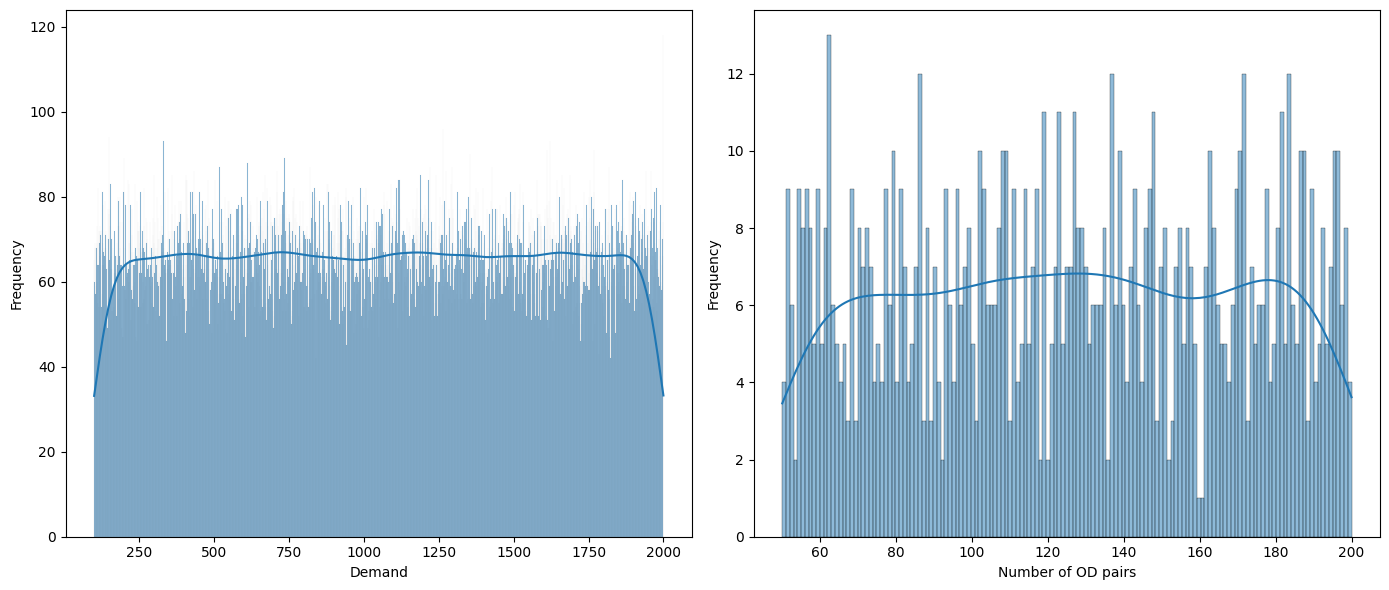

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1,2, 1)
sns.histplot(demand, bins=2000-100, kde=True)
plt.xlabel('Demand')
plt.ylabel('Frequency')

plt.subplot(1,2, 2)
sns.histplot(od_pair, bins=np.max(od_pair)-np.min(od_pair)+1, kde=True)
# sns.histplot(od_pair, bins=200, kde=True)
plt.xlabel('Number of OD pairs')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [24]:
a_file = open("od_demand_list.pkl", "rb")
output = pickle.load(a_file)
a_file.close()

sorted(output[0].items())

[((1, 2), 890),
 ((1, 6), 1454),
 ((1, 9), 535),
 ((1, 15), 1733),
 ((1, 16), 1429),
 ((1, 17), 1015),
 ((1, 18), 890),
 ((1, 21), 1874),
 ((2, 3), 1098),
 ((2, 8), 1027),
 ((2, 12), 421),
 ((2, 23), 275),
 ((3, 1), 1233),
 ((3, 16), 1910),
 ((3, 18), 620),
 ((3, 19), 710),
 ((3, 20), 1297),
 ((3, 21), 152),
 ((3, 22), 1081),
 ((3, 23), 639),
 ((4, 6), 964),
 ((4, 8), 207),
 ((4, 12), 1558),
 ((4, 15), 695),
 ((4, 21), 248),
 ((5, 6), 367),
 ((5, 7), 417),
 ((5, 9), 1988),
 ((5, 15), 588),
 ((5, 23), 1481),
 ((6, 1), 1275),
 ((6, 2), 1877),
 ((6, 15), 1502),
 ((6, 17), 310),
 ((6, 18), 856),
 ((6, 21), 1005),
 ((6, 23), 1144),
 ((7, 5), 1589),
 ((7, 13), 2000),
 ((7, 14), 1622),
 ((7, 18), 747),
 ((7, 20), 1636),
 ((7, 21), 1710),
 ((7, 23), 186),
 ((8, 2), 662),
 ((8, 3), 104),
 ((8, 15), 1479),
 ((8, 19), 643),
 ((8, 20), 610),
 ((9, 4), 1001),
 ((9, 5), 1781),
 ((9, 12), 1110),
 ((9, 15), 464),
 ((9, 16), 123),
 ((9, 20), 168),
 ((10, 3), 1091),
 ((10, 4), 570),
 ((10, 7), 1493),
 (

Read predicted output

In [4]:
def load_from_file(filename):
    with open(filename, 'r') as f:
        data = np.loadtxt(f)
    num_tensors = data.size // (3 * 625)
    reshaped_data = data.reshape((num_tensors, 3, 625))
    tensors = [tf.convert_to_tensor(reshaped_data[i], dtype=tf.float32) for i in range(num_tensors)]
    return tensors

predicted_values = load_from_file('../predicted_result.txt')
print(len(predicted_values))

10


In [23]:
def extract_flow(tensor):
  # input: a single tensor of predicted path flow
  # return a dictionary of full information: od pair,predicted path flow
  final_dict = {}
  for sub_flow_index, sub_flow in enumerate(tensor):
    sub_flow_dict = {(i+1, j+1): int(sub_flow[i, j]) for i in range(sub_flow.shape[0]) for j in range(sub_flow.shape[1])}

    for key, value in sub_flow_dict.items():
        if key not in final_dict:
            final_dict[key] = [None] * tensor.shape[0]
        final_dict[key][sub_flow_index] = value
  final_dict = {k: v for k, v in final_dict.items() if not all(val == 0 for val in v)}
  return final_dict

def create_pred_df(tensor, stat):
  final_dict = extract_flow(tensor)
  print("Number of OD pairs predicted: ", len(final_dict))
  print("Number of origin OD pairs: ", len(stat['path_flow']))
  
  flow_df = pd.DataFrame.from_dict(final_dict, orient='index', columns=['pred_f1', 'pred_f2', 'pred_f3']).reset_index()
  flow_df.rename(columns={'index': 'od'}, inplace=True)
  pred_df = get_origin_path(stat)[['od', 'demand', 'path1', 'path2', 'path3']]
  pred_df = pd.merge(pred_df, flow_df, how='left', on='od')
  nan_val = pred_df['pred_f1'].isna().sum()
  # Percentage of nan value
  print("Nan values: ", nan_val, " -- ", round(nan_val/len(stat['path_flow'])*100,2), "%")
  pred_df = pred_df.fillna(0)
  return pred_df

# Calculate link flow from pred path flow
def sum_pred_link_flow(pred_df, stat):
    pred_path_flow = pred_df[['pred_f1', 'pred_f2', 'pred_f3']].values.tolist()
    path_link = stat['data']['paths_link']

    pred_link_flow = extract_link_flow(path_link, pred_path_flow)
    pred_link_flow = pd.DataFrame.from_dict(pred_link_flow, orient='index', columns=['pred_link_flow']).sort_index(ascending=True).reset_index()
    pred_link_flow.rename(columns={'index': 'link_id'}, inplace=True)
    link = stat['data']['network'].copy()[['link_id', 'capacity', 'free_flow_time', 'b']]
    output = pd.merge(link, pred_link_flow, how='left', on='link_id')
    output = output.fillna(0)
    output['link_cost'] = round(output['free_flow_time']*\
                            (1+output['b']*((output['pred_link_flow']/output['capacity'])**1)), 2)
    return output

def calculate_delay(pred_df, pred_link_flow):
    pred_df['path1_cost'] = pred_df['path1'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path2_cost'] = pred_df['path2'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path3_cost'] = pred_df['path3'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['min_path_cost'] = pred_df[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    pred_df['delay'] = (
        pred_df['pred_f1'] * (pred_df['path1_cost'] - pred_df['min_path_cost']) +
        pred_df['pred_f2'] * (pred_df['path2_cost'] - pred_df['min_path_cost']) +
        pred_df['pred_f3'] * (pred_df['path3_cost'] - pred_df['min_path_cost'])
    )
    avg_delay = pred_df['delay'].sum()/pred_df['demand'].sum()
    #return average delay in minutes
    return avg_delay*60

def single_avg_delay(pred_tensor, filename):
    stat = read_file(filename)
    a = tf.reshape(pred_tensor, (3, 25, 25))
    pred_df = create_pred_df(a, stat)
    pred_link_flow = sum_pred_link_flow(pred_df, stat)
    avg_delay = calculate_delay(pred_df, pred_link_flow)
    return avg_delay

In [30]:
%run ../parameters.py
p = Params()

# Check number of OD pair in origin dataset 
start_from=1800
files = []
for i in range(10):
    file_name = ''.join([p.base_path, str(start_from+i)])
    files.append(file_name)
    

In [31]:
# Check len of predicted path flow distribution
filename = '../Output/5by5_Data1800'

sum_delay = 0
for i, filename in zip(predicted_values, files):
    avg_delay = single_avg_delay(i, filename)
    sum_delay += avg_delay
    print(f"Average delay: {round(avg_delay,3)} mins")
    print("-----------------------------")
print("avg delay of prediction: ", sum_delay/len(predicted_values))

Number of OD pairs predicted:  322
Number of origin OD pairs:  127
Nan values:  54  --  42.52 %
Average delay: 3.817 mins
-----------------------------
Number of OD pairs predicted:  317
Number of origin OD pairs:  127
Nan values:  54  --  42.52 %
Average delay: 4.133 mins
-----------------------------
Number of OD pairs predicted:  311
Number of origin OD pairs:  127
Nan values:  51  --  40.16 %
Average delay: 1.65 mins
-----------------------------
Number of OD pairs predicted:  315
Number of origin OD pairs:  127
Nan values:  54  --  42.52 %
Average delay: 3.999 mins
-----------------------------
Number of OD pairs predicted:  318
Number of origin OD pairs:  127
Nan values:  58  --  45.67 %
Average delay: 3.455 mins
-----------------------------
Number of OD pairs predicted:  317
Number of origin OD pairs:  127
Nan values:  60  --  47.24 %
Average delay: 3.42 mins
-----------------------------
Number of OD pairs predicted:  322
Number of origin OD pairs:  127
Nan values:  43  --  33